In [1]:
%config Completer.use_jedi = False # in case your autocomplete does not work

You might notice that LeNet is too simple for CIFAR-10.
Therefore, you might add complexities to the architecture, e.g., adding more layers or adding more filters, to the point that you don't have enough resources to improve the accuracy. 
In other words, you think that you need to have as deep networks as modern CNN architecture as in AlexNet, GoogleNet, etc. See the following figure. The x-axis is linearly proportional to the number of parameters, which reflects the size of the architecture.

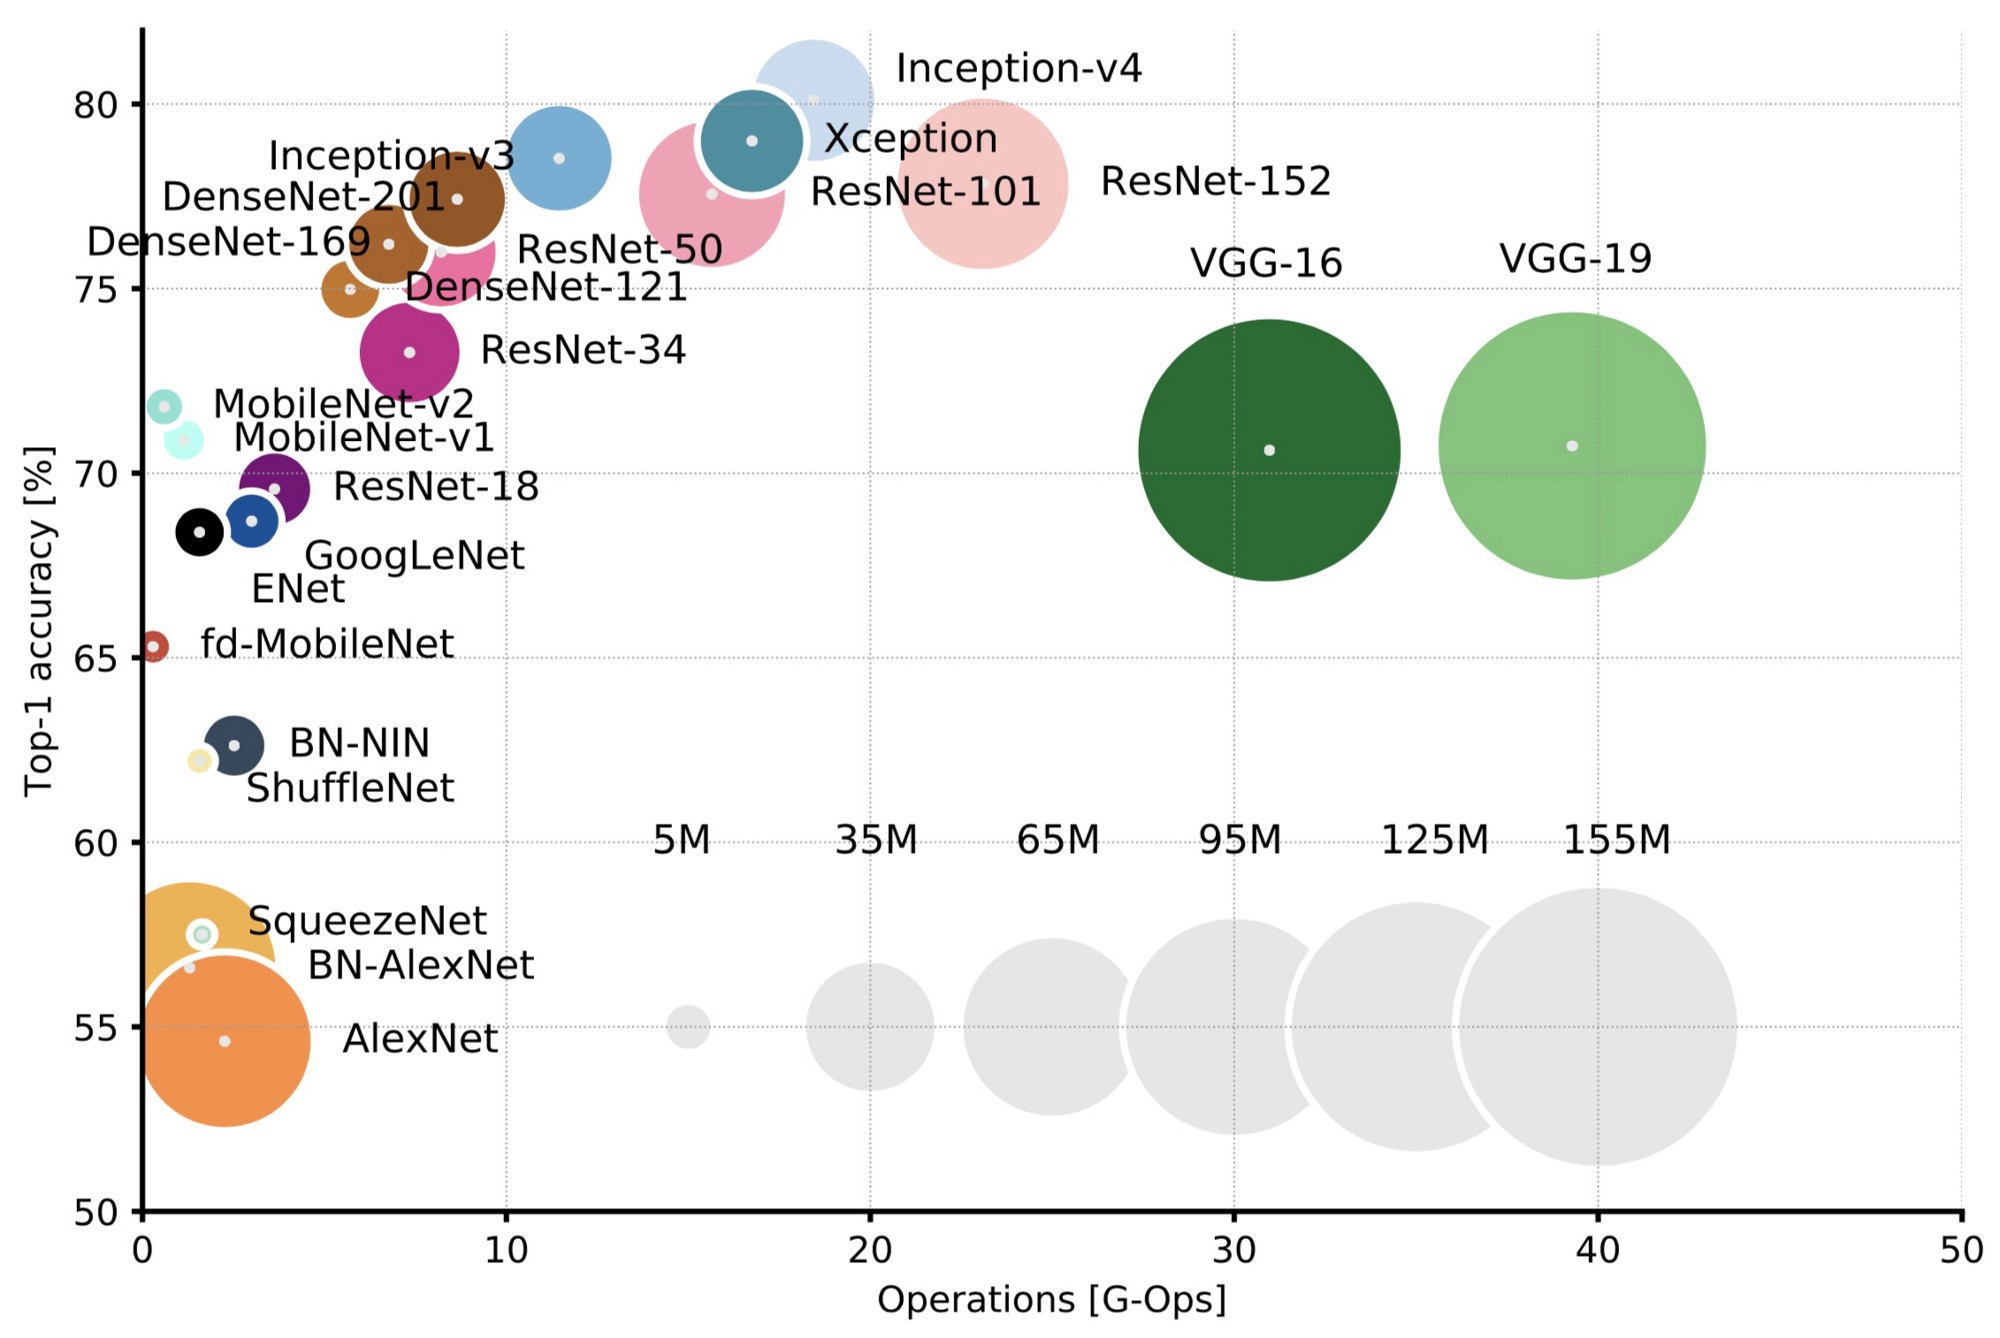

Moreover, you still worked with 10 output classes.
A larger (arguably the largest) image database is ImageNet, which has 1000 output classes.
(You can find details about the classes here, https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)
We got to admit that we simply need more resources.


So, the idea of transfer learning is to enable us doing a training with a very deep network. How?
Recall that CNN has two big layers, i.e., feature learning layer and fully-connected neural network.
Transfer learning can be done such that the weight parameters of the feature learning of a pretrained model is freezed, while freeing the weights of fully-connecated neural network when we do a training in a different (but similar) dataset.
This is called fine-tuning.
Note that the dataset needs to share the same traits, e.g., do not fine tuning a network that is pretrained for audio datasets for image datasets.


# Import and Subroutines

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchvision import datasets, transforms
# from pytorch_lightning.metrics.functional import accuracy
from torchmetrics.functional import accuracy
from torch.utils.data import DataLoader, random_split 

import requests
from PIL import Image


In [3]:
def tensor_to_imgnumpy(image: torch.Tensor, denormalize=False) -> np.ndarray:
    assert image.dim() == 3, f"expecting [3,256,256], the input size is {image.size()}" 
    
    imgnumpy = image.numpy()
    if denormalize:
        imgnumpy = imgnumpy*np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    
    imgnumpy = imgnumpy.clip(0, 1)
    return imgnumpy.transpose(1,2,0)

In [4]:
cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse','ship','truck')

In [5]:
def imshow(imgnumpy: np.ndarray, label, denormalize=False):
    plt.imshow(tensor_to_imgnumpy(imgnumpy,denormalize=denormalize))
    plt.title(cifar_classes[label])

# MobileNet-v2

Let's be clear about one thing.
We're gonna improve LeNet for CIFAR-10 with one of the architectures in the image above.
But, the recent years' architectures are way too complex for our goal.
So, we'll use mobilenet-v2 due to its simplicity compared to other architectures that have superior performance. 
We'll see later that it is quite good.

In [6]:
# Instantiate the pretrained model
# ref: https://github.com/huyvnphan/PyTorch_CIFAR10
from cifar10_models.mobilenetv2 import mobilenet_v2
model = mobilenet_v2(pretrained=True)

# print this if you want to see details of mobilenet
# WARNING: you'll scroll multiple times until you reach the next cell :D. So, I'll comment it for now
# print(model)


Let's naively try it for a random image.


Image size = (1920, 840)


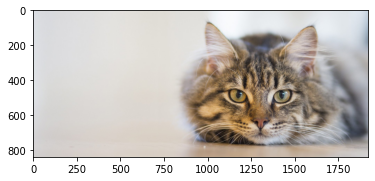

In [7]:
# Get the image from the Internet
url = 'https://icatcare.org/app/uploads/2018/06/Layer-1704-1920x840.jpg'

response = requests.get(url,stream=True)

image = Image.open(response.raw)
plt.imshow(image)
print(f'Image size = {image.size}')

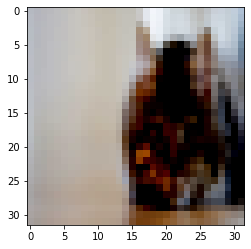

In [8]:
# Define transformation
# https://pytorch.org/hub/pytorch_vision_alexnet/ for a reference to do transformations

tf_resize = transforms.Resize((32,32)) 
tf_totensor = transforms.ToTensor()
tf_normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
tf_compose = transforms.Compose([
    tf_resize,
    tf_totensor,
    tf_normalize,
])

# Transform it to see if the output makes sense
tensor = tf_compose(image)
plt.imshow(tensor_to_imgnumpy(tensor))

See if the pretrained model can detect the image above.

In [9]:
print(cifar_classes[model.forward(tensor.unsqueeze(0)).argmax()])

cat


Is it correct?

# Finetuning

The goal of this exercise is to validate if we can easily obtain a good accuracy with a pretrained model thas has been trained with the CIFAR-10 dataset before.
The model should consist of two main layers, i.e., feature learning layer and classifier layer (or fully connected neural network).
So, we are gonna freeze the feature learning layer, and finetune the classifier layer.

In [10]:
class CifarDetection(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        # load pretrained model
        model = mobilenet_v2(pretrained=True)
        
        self.features = model.features
        self.classifier = model.classifier
        
        # freeze the feature learning
        for param in self.features.parameters():
              param.requires_grad = False #--> FREEZ
        
        # change the number of output classes of the last layer
        # this is useless line as it the number of output classes is already set to be 10
        self.classifier[-1] = nn.Linear(
            in_features=self.classifier[-1].in_features,
            out_features=10)
        
        tf_resize = transforms.Resize((32,32)) # make sure that all loaded images have these dimensions
        tf_totensor = transforms.ToTensor() # Why? pytorch uses this datatype
        tf_normalize = transforms.Normalize(mean=((.5,.5,.5)),std=((.5,.5,.5))) 
        self.tf_compose = transforms.Compose([
            tf_resize,
            tf_totensor,
            tf_normalize,
        ])
        
    def forward(self,x):
#         import pdb; pdb.set_trace()
        x = self.features(x)
        x = x.mean([2, 3])
        x = self.classifier(x)
        
        return x
    
    def training_step(self, batch, batch_idx):
        # Copy paste from the previous article
        inputs, labels = batch
        
        outputs = self.forward(inputs)
        loss = F.cross_entropy(outputs,labels) # --> NEW. Using nn.CrossEntropyLoss
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        # This is new, but the structure is the same as training_step
        inputs, labels = batch
        
        outputs = self.forward(inputs)
        loss = F.cross_entropy(outputs,labels)
        
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy(preds, labels) # --> NEW
        
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # This is new, but the structure is the same as test_step
        # but I replace val_loss --> test_loss etc
        inputs, labels = batch
        
        outputs = self.forward(inputs)
        loss = F.cross_entropy(outputs,labels)
        
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy(preds, labels)
        
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download once
        datasets.CIFAR10(root='./', train=True, download=True)
        datasets.CIFAR10(root='./', train=False, download=True)
    
    def setup(self, stage=None):
        # split, transform, secretly move to GPU (if needed) by PL (not by us)
        if stage == 'fit' or stage is None:
            cifar_full = datasets.CIFAR10(root='./', train=True, transform=self.tf_compose)
            self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000])
            
        if stage == 'test' or stage is None:
            self.cifar_test = datasets.CIFAR10(root='./', train=False, transform=self.tf_compose)
            
#         import pdb; pdb.set_trace()
            
    def train_dataloader(self): 
        return DataLoader(self.cifar_train, batch_size=100, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=100, num_workers=2)
    
    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=100, num_workers=2)

Now, let's train it again see if we can obtain a good accuracy starting from the very first epoch.

In [11]:
pl.seed_everything(1412) # --> for consistency, change the number with your favorite number :D

model = CifarDetection()

# most basic trainer, uses good defaults (auto-tensorboard, checkpoints, logs, and more)
try:
    trainer = pl.Trainer(gpus=1,max_epochs=5,default_root_dir='./cifar_logs')
except Exception as e:
    # most likely due to GPU, so fallback to non GPU
    print(e)
    trainer = pl.Trainer(max_epochs=5,default_root_dir='./cifar_logs')
    
trainer.fit(model)

Global seed set to 1412
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
------------------------------------------
0 | features   | Sequential | 2.2 M 
1 | classifier | Sequential | 12.8 K
------------------------------------------
12.8 K    Trainable params
2.2 M     Non-trainable params
2.2 M     Total params
8.947     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from to

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [12]:
trainer.test()

/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1446: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at cifar_logs/lightning_logs/version_1/checkpoints/epoch=4-step=2250.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at cifar_logs/lightning_logs/version_1/checkpoints/epoch=4-step=2250.ckpt
/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9103000164031982
        test_loss           0.3290537893772125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3290537893772125, 'test_acc': 0.9103000164031982}]

In [13]:
%reload_ext tensorboard
%tensorboard --logdir cifar_logs/

Reusing TensorBoard on port 6007 (pid 121732), started 0:02:04 ago. (Use '!kill 121732' to kill it.)

See, you can easily get 90% of accuracy with only a few epoch.

Lastly, sometimes it is also important to see how the original model was trained, for example, what transformations that were applied to the dataset. (see https://github.com/huyvnphan/PyTorch_CIFAR10/blob/master/data.py)